\begin{align*}
u_t &= u_{xx} \\
u_t(t,x) &= \frac{u(t,x+ \Delta x)-2u(t,x)+u(t,x- \Delta x)}{\Delta x^{2}} \\
u_t(t,x) + \frac{2}{\Delta x^{2}}u(t,x) &= \frac{u(t,x+ \Delta x)+u(t,x- \Delta x)}{\Delta x^{2}} \\
u(t,x) &= e^{-\frac{2}{\Delta x^{2}} t} \left[u(0,x) 
+ \frac{1}{\Delta x^{2}} \int_{0}^{t} e^{\frac{2}{\Delta x^{2}} s} 
(u(s,x+ \Delta x)+u(s,x- \Delta x))ds  \right] 
\end{align*}

In [8]:
from random import random as U
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# def u(t,x): return x**2 + 2*t #needs to satisfy heat equation
def u(t,x): return 2*x*t + x**3/3 #needs to satisfy heat equation
def Pheat(t,q): return np.exp(-q*t)
def Gheat(t,s,q): return np.exp(q*(s-t)) 


def Z0(t,x,dx,dt):
    a =2/dx**2 
    sol = Pheat(t,a)*u(0,x)
    s = t*U()
    xnew = x+dx if U()<1/2 else x-dx
    if U()<t/dt:
        sol+=2*Gheat(t,s,a)*Z0(s,xnew,dx,dt)*dt/dx**2
    return sol

def Z(t,x,dx,dt):
    if t< dt: return Z0(t,x,dx,dt) 
    t0 = t-dt
    a =2/dx**2 
    s = dt*U()+t0
    xnew = x+dx if U()<1/2 else x-dx
    samp = np.exp(-a*dt)/(0.5+np.exp(-a*dt))
    if U()<samp: 
        sol = Pheat(dt,a)*Z(t0,x,dx,dt)/samp
    else:
        sol=2* Gheat(t,s,a)*Z(s,xnew,dx,dt)*dt/dx**2 / (1-samp)
    return sol

# Number of simulations

# Function to update and display the histogram
def update_histogram(t,x,dt, dx,nsim):
    nsim = 10**int(nsim)
    zz = np.array([Z(t, x, dx, dt) for _ in range(nsim)])
    avg_label.value = f"Updated Average of zz: {np.average(zz):.2f}, {u(t,x):.2f}"
    plt.hist(zz, bins=int(nsim/20+1))
    plt.xlabel("Values of Z")
    plt.ylabel("Frequency")
    plt.title("Histogram of Z")
    plt.show()

# Create sliders for dt and dx
dt_slider = widgets.FloatSlider(value=1, min=0.01, max=1, step=0.01, description='dt:')
dx_slider = widgets.FloatSlider(value=1, min=0.01, max=10, step=0.1, description='dx:')
t_slider = widgets.FloatSlider(value=0, min=0, max=10.0, step=0.1, description='t:')
x_slider = widgets.FloatSlider(value=0, min=-50, max=50, step=1, description='x:')
nsim_slider = widgets.FloatSlider(value=0, min=0, max=5, step=1, description='nsim:')

# Create a label to display the average of zz
avg_label = widgets.Label(value="")

# Create an interactive interface
display(avg_label)
interact(update_histogram,t=t_slider,x=x_slider, dt=dt_slider, dx=dx_slider, nsim = nsim_slider)

Label(value='')

interactive(children=(FloatSlider(value=0.0, description='t:', max=10.0), FloatSlider(value=0.0, description='…

<function __main__.update_histogram(t, x, dt, dx, nsim)>

now with importance sampling

100.8294


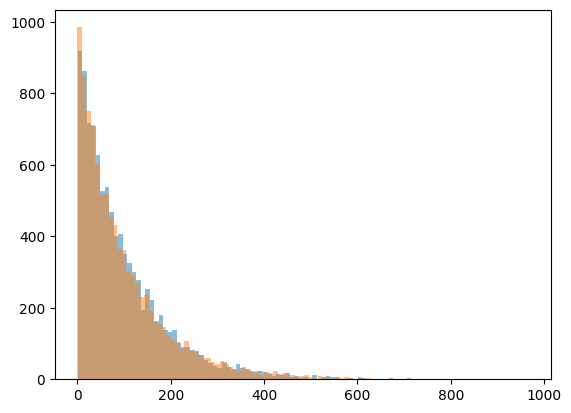

In [28]:
@njit(fastmath=True)
def geo(p):
    sol = 1
    while U()>p:
        sol+=1
    return sol

d= [geo(1/100) for _ in range(10**4)]
b= [-np.log(U())*100 for _ in range(10**4)]
print(np.mean(d))
plt.hist(d,bins=100,alpha = 0.5)
plt.hist(b,bins=100,alpha = 0.5)
plt.show()


In [1]:
from random import random as U
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# @njit(fastmath=True)
# def u(t,x): return x**2 + 2*t #needs to satisfy heat equation
@njit(fastmath=True)
def u(t,x): return 2*x*t + x**3/3 #needs to satisfy heat equation


@njit(fastmath=True)
def Pheat(t,q): return np.exp(-q*t)

@njit(fastmath=True)
def geo(p):
    sol = 1
    while U()>p:
        sol+=1
    return sol


@njit(fastmath=True)
def Z0(t,x,dx):
    a =2.0/dx**2 
    sol = 0.0
    while True:
        l = 1/a if Pheat(t,a)<1/a else Pheat(t,a)
        n = geo(l) if l>0.01 else int(-np.log(U())/l) 
        if n<1000:
            for _ in range(n):
                t+=np.log(U())/a 
        else:
                t+=-n/a 
        if t<0: 
            break 
        x += dx*np.sqrt(n)*np.random.normal(0,1)
        sol += Pheat(t,a)*u(0,x)/l  
    return sol

# @njit(fastmath=True)
# def Z0(t,x,dx):
#     # if abs(x)>10: return u(t,x) # boundary condition test
#     a =2.0/dx**2 
#     s= t+np.log(U())/a
#     sol = Pheat(t,a)*u(0,x) 
#     xnew = x+dx if U()<1/2 else x-dx
#     sol+=Z0(s,xnew,dx)  if s>0 else 0.0
#     return sol

@njit(fastmath=True, parallel=True)
def z0(t,x,dx, nsim):
    total = 0.0 # <- typing becomes important 0 vs 0.0
    for _ in prange(nsim): # numba likes explicit loops sometimes even over vectorized numpy
        total += Z0(t,x,dx)
    return total/nsim

# Function to update and display the histogram
def update_histogram(t,x, dx,nsim):
    nsim = 10**int(nsim)
    sol = z0(t,x,dx,nsim)
    avg_label.value = f"Updated Average of zz: {sol:.2f}, {u(t,x):.2f}, acc: {100*(sol-u(t,x))/(u(t,x)+0.00001):.2f}%"
    if nsim<=10**3:
        zz = np.array([Z0(t, x, dx) for _ in range(nsim)])
        plt.hist(zz, bins=int(nsim/20+1))
        plt.xlabel("Values of Z")
        plt.ylabel("Frequency")
        plt.title("Histogram of Z")
        plt.show()

# Create sliders for dt and dx
dx_slider = widgets.FloatSlider(value=1, min=0.01, max=1, step=0.01, description='dx:')
t_slider = widgets.FloatSlider(value=1, min=0, max=10.0, step=0.1, description='t:')
x_slider = widgets.FloatSlider(value=1, min=-50, max=50, step=1, description='x:')
nsim_slider = widgets.FloatSlider(value=3, min=0, max=6, step=1, description='nsim:')

# Create a label to display the average of zz
avg_label = widgets.Label(value="")

# Create an interactive interface
display(avg_label)
interact(update_histogram,t=t_slider,x=x_slider, dx=dx_slider, nsim = nsim_slider)

Label(value='')

interactive(children=(FloatSlider(value=1.0, description='t:', max=10.0), FloatSlider(value=1.0, description='…

<function __main__.update_histogram(t, x, dx, nsim)>

In [1]:
from random import random as U
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# @njit(fastmath=True)
# def u(t,x): return x**2 + 2*t #needs to satisfy heat equation

def u(t,x): return 2*x*t + x**3/3 #needs to satisfy heat equation
def Pheat(t,q): return np.exp(-q*t)

points = []

def Z0(t,x,dx):
    a =2.0/dx**2 
    sol = Pheat(t,a)*u(0,x)
    s = t-np.random.exponential(scale=1/a,size=1)[0]
    xnew = x+dx if U()<1/2 else x-dx
    sol+=Z0(s,xnew,dx) if s>0 else 0.0
    global points
    points.append((t,x))
    return sol

def update_plot(t,x, dx,nsim):
    global points 
    points = []
    Z0(t,x,dx)
    tt,xx  = zip(*points)
    plt.plot(tt,xx)
    plt.show()

# Create sliders for dt and dx
dx_slider = widgets.FloatSlider(value=0.5, min=0.1, max=10, step=0.1, description='dx:')
t_slider = widgets.FloatSlider(value=8, min=0, max=10.0, step=0.1, description='t:')
x_slider = widgets.FloatSlider(value=1, min=-50, max=50, step=1, description='x:')
nsim_slider = widgets.FloatSlider(value=5, min=0, max=6, step=1, description='nsim:')

interact(update_plot,t=t_slider,x=x_slider, dx=dx_slider, nsim = nsim_slider)

interactive(children=(FloatSlider(value=8.0, description='t:', max=10.0), FloatSlider(value=1.0, description='…

<function __main__.update_plot(t, x, dx, nsim)>